<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/discharge_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dataretrieval
!pip install scores

In [98]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from google.colab import drive
from matplotlib import pyplot as plt
import datetime
import glob
from tqdm import tqdm
from scipy.stats import lognorm, linregress
from dataretrieval import nwis

from scores.continuous import nse, kge, rmse, multiplicative_bias
from scores.continuous.correlation import pearsonr

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
merit_centerlines = gpd.read_file('/content/drive/MyDrive/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01.shp').to_crs(3857)

<Axes: >

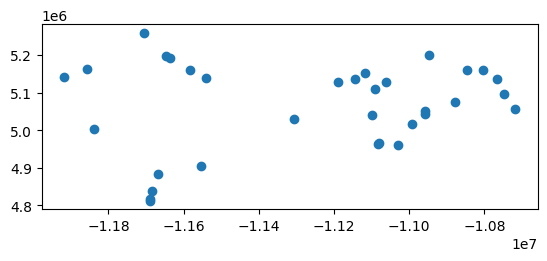

In [5]:
gage_list = ['06764880', '06775900', '06775500', '06770200', '06767970', '06768000',
             '06784000', '06781900', '06785000', '06790500', '06800500', '06793000',
             '06800000', '06777495', '06786000', '06799350', '06799315', '06799000',
             '06797500', '06785500', '06710247', '06711565', '06714215', '06721000',
             '06759500', '06620000', '06680500', '06630000', '06674500', '06635000',
             '06670500', '06657000', '06652000']


gage_gdf = nwis.get_info(sites=gage_list)[0][['site_no', 'geometry']]
gage_gdf = gpd.GeoDataFrame(gage_gdf, geometry=gage_gdf.geometry, crs=4269)\
    .to_crs(3857)

gage_gdf.plot()

<Axes: >

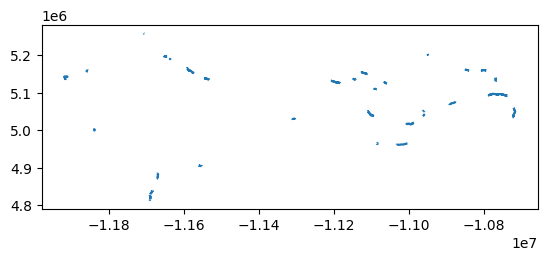

In [6]:
gage_merits = gpd.sjoin_nearest(gage_gdf, merit_centerlines, distance_col='mg_dist')
gage_merits = pd.merge(gage_merits.rename(columns={'geometry': 'pointgeom'}), merit_centerlines[['COMID', 'geometry']].rename(columns={'geometry': 'linegeom'}), on='COMID')
gage_merits = gage_merits.set_geometry('linegeom')
gage_merits.plot()

In [81]:
gage_Q = nwis.get_dv(sites=gage_list, start='2018-01-01', end='2024-12-31', parameterCd='00060')[0]
gage_Q['00060_Mean'] = gage_Q['00060_Mean'] * (3.28 ** -3)
gage_Q = gage_Q.rename(columns={'00060_Mean': 'USGS_Q', '00060_Mean_cd': 'Q_cd'}).reset_index()

gage_Q['date'] = pd.to_datetime(gage_Q.datetime).dt.date
gage_Q = gage_Q.loc[gage_Q.Q_cd == 'A']
gage_Q = gage_Q[['site_no', 'USGS_Q', 'date']]

gage_Q = pd.merge(gage_Q, gage_merits, how='left', on='site_no')

gage_Q = gpd.GeoDataFrame(gage_Q, geometry=gage_Q.linegeom, crs=3857)

gage_Q

,site_no,USGS_Q,date,pointgeom,index_right,COMID,lengthkm,lengthdir,sinuosity,slope,...,slope_taud,NextDownID,maxup,up1,up2,up3,up4,mg_dist,linegeom,geometry
0,06620000,9.323401,2018-03-24,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
1,06620000,12.128923,2018-03-25,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
2,06620000,12.355632,2018-03-26,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
3,06620000,11.023717,2018-03-27,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
4,06620000,9.748480,2018-03-28,POINT (-11837624.972 5003000.402),163557,74031543,6.781344,4.799888,1.412813,0.000855,...,0.000855,74031541,2,74031544,74033778,0,0,89.772342,"LINESTRING (-11837807.417 5004232.558, -118379...","LINESTRING (-11837807.417 5004232.558, -118379..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67799,06800500,30.038921,2024-12-27,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."
67800,06800500,32.306010,2024-12-28,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."
67801,06800500,33.439554,2024-12-29,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."
67802,06800500,35.990028,2024-12-30,POINT (-10718273.484 5055705.013),160984,74028970,26.709834,18.884663,1.414366,0.000416,...,0.000416,74028908,2,74028971,74031004,0,0,123.606455,"LINESTRING (-10722200.587 5035231.081, -107221...","LINESTRING (-10722200.587 5035231.081, -107221..."


<Axes: >

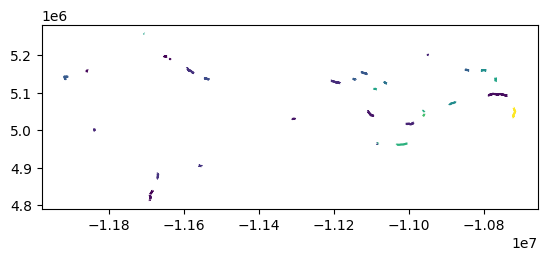

In [82]:
gage_stats = gage_Q.groupby('site_no').agg(
    mean_Q_usgs = ('USGS_Q', lambda x: np.mean(x)),
    median_Q_usgs = ('USGS_Q', lambda x: np.median(x)),
    iqr_Q_usgs = ('USGS_Q', lambda x: np.percentile(x, 75) - np.percentile(x, 25)),
    cqv_Q_usgs = ('USGS_Q', lambda x: (np.percentile(x, 75) - np.percentile(x, 25)) / (np.percentile(x, 75) + np.percentile(x, 25))),
    sd_Q_usgs = ('USGS_Q', lambda x: np.std(x))
)

gage_stats = pd.merge(gage_stats, gage_merits, how='left', on='site_no')

gage_stats = gpd.GeoDataFrame(gage_stats, geometry=gage_stats.linegeom, crs=3857)

gage_stats.plot(column='median_Q_usgs')

In [9]:
Q2024 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc')
Q2023 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2023.nc')
Q2022 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2022.nc')
Q2021 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2021.nc')
Q2020 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2020.nc')
Q2019 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2019.nc')
Q2018 = xr.open_dataset('/content/drive/MyDrive/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2018.nc')

In [12]:
COMID_arr = gage_merits.COMID.unique()

Q2024 = Q2024.sel(rivid=COMID_arr)
Q2023 = Q2023.sel(rivid=COMID_arr)
Q2022 = Q2022.sel(rivid=COMID_arr)
Q2021 = Q2021.sel(rivid=COMID_arr)
Q2020 = Q2020.sel(rivid=COMID_arr)
Q2019 = Q2019.sel(rivid=COMID_arr)
Q2018 = Q2018.sel(rivid=COMID_arr)

all_GRADES_DL = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')

/tmp/ipython-input-1033140463.py:11: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  all_GRADES_DL = xr.concat([Q2018, Q2019, Q2020, Q2021, Q2022, Q2023, Q2024], dim='time')


In [75]:
GRADESDL_df = all_GRADES_DL.to_dataframe()\
    .reset_index()\
    .drop('nerr', axis=1)\
    .drop_duplicates(['time', 'rivid'])\
    .rename(columns={'time': 'date', 'rivid': 'COMID', 'Qout': 'GRADESDL_Q'})

GRADESDL_df.COMID = np.uint32(GRADESDL_df.COMID)

GRADESDL_df.date = pd.to_datetime(GRADESDL_df.date).dt.date

GRADESDL_df = GRADESDL_df.set_index(['date', 'COMID'])

GRADESDL_df

GRADESDL_Q      Qout_err           crs           lon  \
date       COMID                                                            
2018-01-01 74031543    9.433120           NaN           NaN  9.969210e+36   
           74026787   19.832386           NaN           NaN  9.969210e+36   
           74024972    0.014052           NaN           NaN  9.969210e+36   
           74022395   28.811483           NaN           NaN  9.969210e+36   
           74024472   29.278721           NaN           NaN  9.969210e+36   
...                         ...           ...           ...           ...   
2024-12-31 74026765    7.283047  9.969210e+36 -2.147484e+09  9.969210e+36   
           74026718   10.945940  9.969210e+36 -2.147484e+09  9.969210e+36   
           74026714   11.411186  9.969210e+36 -2.147484e+09  9.969210e+36   
           74027435    1.224844  9.969210e+36 -2.147484e+09  9.969210e+36   
           74028970   16.813606  9.969210e+36 -2.147484e+09  9.969210e+36   

                              lat  
date       COMID                   
2018-01-01 74031543  9.969210e+36  
           74026787  9.969210e+36  
           74024972  9.969210e+36  
           74022395  9.969210e+36  
           74024472  9.969210e+36  
...                           ...  
2024-12-31 74026765  9.969210e+36  
           74026718  9.969210e+36  
           74026714  9.969210e+36  
           74027435  9.969210e+36  
           74028970  9.969210e+36  

[84381 rows x 5 columns]

In [63]:
GRFR = xr.open_dataset('/content/drive/MyDrive/GRFR/output_pfaf_07_1979-2019.nc')

GRFR_1819 = GRFR.sel(time=slice('2018-01-01', '2024-12-31'), rivid=COMID_arr)

In [64]:
GRFR_1819 = GRFR_1819\
    .to_dataframe()\
    .reset_index()\
    .drop_duplicates(['time', 'rivid'])\
    .rename(columns={'time': 'date', 'rivid': 'COMID', 'Qout': 'GRFR_Q'})\

GRFR_1819.date = pd.to_datetime(GRFR_1819.date).dt.date

GRFR_1819 = GRFR_1819.set_index(['date', 'COMID'])

In [78]:
GRFR_1819

GRFR_Q
date       COMID              
2018-01-01 74031543   7.411584
           74026787  10.631947
           74024972   0.001758
           74022395  18.599724
           74024472  15.635729
...                        ...
2019-12-31 74026765   8.347904
           74026718  19.124763
           74026714  19.922815
           74027435   9.428254
           74028970  48.290920

[24090 rows x 1 columns]

In [89]:
GRADESDL_USGS = pd.merge(
    gage_Q.set_index(['date', 'COMID'])[['site_no', 'USGS_Q', 'lengthkm', 'pointgeom', 'linegeom']],
    GRADESDL_df[['GRADESDL_Q']],
    on=['date', 'COMID'],
    how='outer'
)

GRADESDL_USGS_GRFR = pd.merge(
    GRADESDL_USGS,
    GRFR_1819,
    on=['date', 'COMID'],
    how='outer'
).reset_index()

GRADESDL_USGS_GRFR

,date,COMID,site_no,USGS_Q,lengthkm,pointgeom,linegeom,GRADESDL_Q,GRFR_Q
0,2018-01-01,74022395,NaN,NaN,NaN,None,None,28.811483,18.599724
1,2018-01-01,74024472,NaN,NaN,NaN,None,None,29.278721,15.635729
2,2018-01-01,74024496,NaN,NaN,NaN,None,None,5.869865,3.412416
3,2018-01-01,74024571,NaN,NaN,NaN,None,None,3.940438,1.940775
4,2018-01-01,74024972,06635000,1.331914,6.539344,POINT (-11856988.296 5162427.799),"LINESTRING (-11857010.029 5162477.513, -118569...",0.014052,0.001758
...,...,...,...,...,...,...,...,...,...
84376,2024-12-31,74034190,06759500,18.108369,8.195289,POINT (-11555095.804 4905022.842),"LINESTRING (-11551530.793 4905255.867, -115515...",17.905384,NaN
84377,2024-12-31,74034214,NaN,NaN,NaN,None,None,7.250729,NaN
84378,2024-12-31,74036975,NaN,NaN,NaN,None,None,5.370095,NaN
84379,2024-12-31,74036977,NaN,NaN,NaN,None,None,4.907434,NaN


In [90]:
GRADESDL_USGS_GRFR

,date,COMID,site_no,USGS_Q,lengthkm,pointgeom,linegeom,GRADESDL_Q,GRFR_Q
0,2018-01-01,74022395,NaN,NaN,NaN,None,None,28.811483,18.599724
1,2018-01-01,74024472,NaN,NaN,NaN,None,None,29.278721,15.635729
2,2018-01-01,74024496,NaN,NaN,NaN,None,None,5.869865,3.412416
3,2018-01-01,74024571,NaN,NaN,NaN,None,None,3.940438,1.940775
4,2018-01-01,74024972,06635000,1.331914,6.539344,POINT (-11856988.296 5162427.799),"LINESTRING (-11857010.029 5162477.513, -118569...",0.014052,0.001758
...,...,...,...,...,...,...,...,...,...
84376,2024-12-31,74034190,06759500,18.108369,8.195289,POINT (-11555095.804 4905022.842),"LINESTRING (-11551530.793 4905255.867, -115515...",17.905384,NaN
84377,2024-12-31,74034214,NaN,NaN,NaN,None,None,7.250729,NaN
84378,2024-12-31,74036975,NaN,NaN,NaN,None,None,5.370095,NaN
84379,2024-12-31,74036977,NaN,NaN,NaN,None,None,4.907434,NaN


In [197]:
comid_list_ascending = gage_stats.sort_values('median_Q_usgs').COMID.tolist()

In [199]:
GRADESDL_USGS_GRFR_x = GRADESDL_USGS_GRFR.drop(['linegeom', 'pointgeom'], axis=1).to_xarray()

In [200]:
tdf = GRADESDL_USGS_GRFR_x.where(GRADESDL_USGS_GRFR_x.COMID == comid_list_ascending[0], drop=True)
tdf

<xarray.Dataset> Size: 153kB
Dimensions:     (index: 2557)
Coordinates:
  * index       (index) int64 20kB 30 63 96 129 162 ... 84279 84312 84345 84378
Data variables:
    date        (index) object 20kB 2018-01-01 2018-01-02 ... 2024-12-31
    COMID       (index) float64 20kB 7.404e+07 7.404e+07 ... 7.404e+07 7.404e+07
    site_no     (index) object 20kB '06714215' '06714215' '06714215' ... nan nan
    USGS_Q      (index) float64 20kB 0.1233 0.121 0.1091 0.1006 ... nan nan nan
    lengthkm    (index) float64 20kB 10.9 10.9 10.9 10.9 ... nan nan nan nan
    GRADESDL_Q  (index) float64 20kB 5.519 5.406 5.371 5.41 ... 5.328 5.445 5.37
    GRFR_Q      (index) float32 10kB 3.734 3.897 3.798 3.505 ... nan nan nan nan

In [232]:
plot = False

GRADESDL_kge = []
GRADESDL_nse = []
GRADESDL_bias = []
GRADESDL_r2 = []
GRADESDL_rmse = []

GRFR_kge = []
GRFR_nse = []
GRFR_bias = []
GRFR_r2 = []
GRFR_rmse = []

if plot:
    fig, axs = plt.subplots(ncols=6, nrows=6, figsize=(18, 18), constrained_layout=True)
for p in range(33):
    tdf = GRADESDL_USGS_GRFR_x.where(GRADESDL_USGS_GRFR_x.COMID == comid_list_ascending[p])
    if len(tdf) > 1:
        if plot:
            ax = axs.flatten()[p]
            # ax.scatter(tdf2.Q_cms, tdf2.Qout, c=tdf2.COMID, alpha=0.05)
            ax.scatter(tdf.USGS_Q, tdf.GRFR_Q)
            ax.set_xlabel('Gage discharge')
            ax.set_ylabel('GRFR discharge')
            ax.set_aspect('equal')

            m = np.max([np.max(tdf.USGS_Q), np.max(tdf.GRADESDL_Q)])
            ax.set_xlim(0, m)
            ax.set_ylim(0, m)
            ax.axline((0, 0), slope=1, color='black')


        GRADESDL_kge.append(kge(tdf.GRADESDL_Q, tdf.USGS_Q).item())
        GRADESDL_nse.append(nse(tdf.GRADESDL_Q, tdf.USGS_Q).item())
        GRADESDL_bias.append(multiplicative_bias(tdf.GRADESDL_Q, tdf.USGS_Q).item())
        GRADESDL_r2.append(pearsonr(tdf.GRADESDL_Q, tdf.USGS_Q).item() ** 2)
        GRADESDL_rmse.append(rmse(tdf.GRADESDL_Q, tdf.USGS_Q).item())

        GRFR_kge.append(kge(tdf.GRFR_Q, tdf.USGS_Q).item())
        GRFR_nse.append(nse(tdf.GRFR_Q, tdf.USGS_Q).item())
        GRFR_bias.append(multiplicative_bias(tdf.GRFR_Q, tdf.USGS_Q).item())
        GRFR_r2.append(pearsonr(tdf.GRFR_Q, tdf.USGS_Q).item() ** 2)
        GRFR_rmse.append(rmse(tdf.GRFR_Q, tdf.USGS_Q).item())

    else:
        GRADESDL_kge.append(-999)
        GRADESDL_nse.append(-999)
        GRADESDL_bias.append(-999)
        GRADESDL_r2.append(-999)
        GRADESDL_rmse.append(-999)

        GRFR_kge.append(-999)
        GRFR_nse.append(-999)
        GRFR_bias.append(-999)
        GRFR_r2.append(-999)
        GRFR_rmse.append(-999)



GRADESDL_kge.append(kge(GRADESDL_USGS_GRFR_x.GRADESDL_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())
GRADESDL_nse.append(nse(GRADESDL_USGS_GRFR_x.GRADESDL_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())
GRADESDL_bias.append(multiplicative_bias(GRADESDL_USGS_GRFR_x.GRADESDL_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())
GRADESDL_r2.append(pearsonr(GRADESDL_USGS_GRFR_x.GRADESDL_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item() ** 2)
GRADESDL_rmse.append(rmse(GRADESDL_USGS_GRFR_x.GRADESDL_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())

GRFR_kge.append(kge(GRADESDL_USGS_GRFR_x.GRFR_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())
GRFR_nse.append(nse(GRADESDL_USGS_GRFR_x.GRFR_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())
GRFR_bias.append(multiplicative_bias(GRADESDL_USGS_GRFR_x.GRFR_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())
GRFR_r2.append(pearsonr(GRADESDL_USGS_GRFR_x.GRFR_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item() ** 2)
GRFR_rmse.append(rmse(GRADESDL_USGS_GRFR_x.GRFR_Q, GRADESDL_USGS_GRFR_x.USGS_Q).item())

stat display

In [233]:
Qlist = gage_stats.sort_values('median_Q_usgs').median_Q_usgs.tolist()
Qlist.append(-1000)

disp_df = pd.DataFrame({
    'index': range(0, 34),
    'COMID': comid_list_ascending.append(1000),
    'median_Q': Qlist,
    'GRADES_DL_KGE': GRADESDL_kge,
    'GRADES_DL_NSE': GRADESDL_nse,
    'GRADES_DL_bias': GRADESDL_bias,
    'GRADES_DL_r2': GRADESDL_r2,
    'GRADES_DL_rmse': GRADESDL_rmse,
    'GRFR_KGE': GRFR_kge,
    'GRFR_NSE': GRFR_nse,
    'GRFR_bias': GRFR_bias,
    'GRFR_r2': GRFR_r2,
    'GRFR_rmse': GRFR_rmse
})

In [234]:
disp_df

,index,COMID,median_Q,GRADES_DL_KGE,GRADES_DL_NSE,GRADES_DL_bias,GRADES_DL_r2,GRADES_DL_rmse,GRFR_KGE,GRFR_NSE,GRFR_bias,GRFR_r2,GRFR_rmse
0,0,None,0.497343,-1.196949,-1.630370,3.081201,0.350729,13.755909,-41.419289,-15629.489304,34.377426,0.016071,3.914909
1,1,None,0.776478,-6.937192,-57.879826,6.406836,0.028122,170.187482,-1.412456,-4.947834,3.049023,0.065572,64.304689
2,2,None,1.312077,-0.453817,-0.466788,0.009308,0.363918,7.475674,-0.544526,-0.546026,0.002139,0.136715,7.638626
3,3,None,1.327664,-1.937453,-4.701030,3.588882,0.474478,12.017836,-3.977139,-12.814468,5.272912,0.530294,20.178179
4,4,None,1.499112,-13.224145,-223.284567,8.698455,0.191826,32.706352,-3.798797,-28.032259,4.269954,0.421526,13.192316
5,5,None,2.118311,-1.201681,-3.355508,2.811621,0.553226,12.266975,-3.402276,-15.236788,4.312222,0.556039,20.316767
6,6,None,2.218913,0.565318,0.392093,1.073625,0.409452,6.398001,0.330357,0.228519,0.815938,0.246250,12.229775
7,7,None,3.542326,0.266967,-0.345503,0.482920,0.231629,4.021749,0.031961,-0.159554,0.488562,0.084947,6.780509
8,8,None,3.570664,-5.285823,-10.413477,7.020913,0.249946,72.558338,-6.090602,-54.712907,6.450673,0.207216,61.082822
9,9,None,5.696060,0.537905,0.407913,0.813580,0.425885,13.282956,0.023150,0.047853,0.763786,0.072323,31.262208
